 Lab 10: MNIST Compression using Denoising Autoencoder
 Advanced Visualization + Metrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim
import seaborn as sns
import kagglehub

Download MNIST dataset using Kaggle API

In [ ]:
path = kagglehub.dataset_download("arnavsharma45/mnist-dataset")
print("Path to dataset files:", path)

100%|██████████| 9.14M/9.14M [00:01<00:00, 6.29MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arnavsharma45/mnist-dataset/versions/1


Data preparation

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


Define Denoising Autoencoder

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, encoding_dim=64):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

Noise Function

In [ ]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    noisy = torch.clip(noisy, -1.0, 1.0)
    return noisy


Setup model, loss, optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training with visualization checkpoints

Epoch [1/15] | Train: 0.1725 | Val: 0.0954 | PSNR: 16.78 | SSIM: 0.688
Epoch [2/15] | Train: 0.0789 | Val: 0.0691 | PSNR: 18.31 | SSIM: 0.766
Epoch [3/15] | Train: 0.0608 | Val: 0.0561 | PSNR: 19.25 | SSIM: 0.806
Epoch [4/15] | Train: 0.0517 | Val: 0.0492 | PSNR: 19.80 | SSIM: 0.828
Epoch [5/15] | Train: 0.0466 | Val: 0.0454 | PSNR: 20.21 | SSIM: 0.839


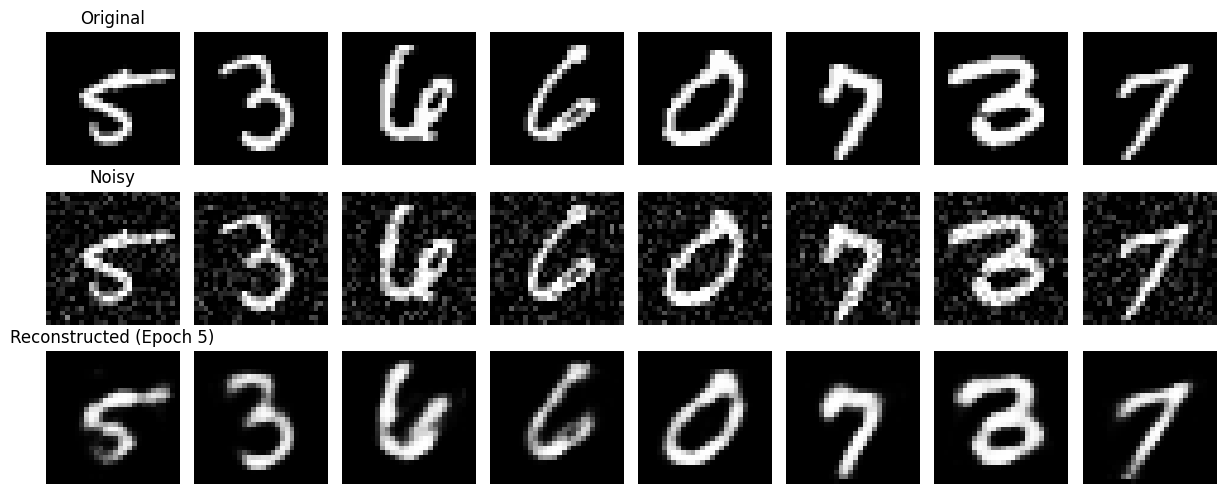

Epoch [6/15] | Train: 0.0432 | Val: 0.0424 | PSNR: 20.46 | SSIM: 0.850
Epoch [7/15] | Train: 0.0405 | Val: 0.0402 | PSNR: 20.70 | SSIM: 0.856
Epoch [8/15] | Train: 0.0385 | Val: 0.0379 | PSNR: 20.95 | SSIM: 0.863
Epoch [9/15] | Train: 0.0366 | Val: 0.0363 | PSNR: 21.16 | SSIM: 0.868
Epoch [10/15] | Train: 0.0349 | Val: 0.0348 | PSNR: 21.33 | SSIM: 0.871


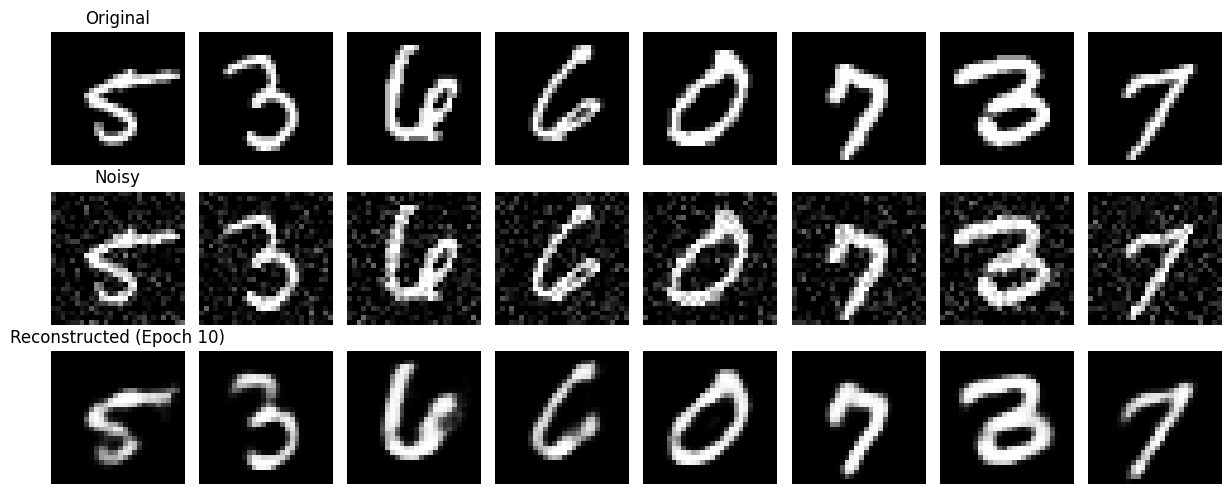

Epoch [11/15] | Train: 0.0335 | Val: 0.0346 | PSNR: 21.31 | SSIM: 0.872
Epoch [12/15] | Train: 0.0323 | Val: 0.0332 | PSNR: 21.44 | SSIM: 0.876
Epoch [13/15] | Train: 0.0312 | Val: 0.0313 | PSNR: 21.76 | SSIM: 0.882
Epoch [14/15] | Train: 0.0302 | Val: 0.0304 | PSNR: 21.88 | SSIM: 0.886
Epoch [15/15] | Train: 0.0295 | Val: 0.0303 | PSNR: 21.87 | SSIM: 0.885


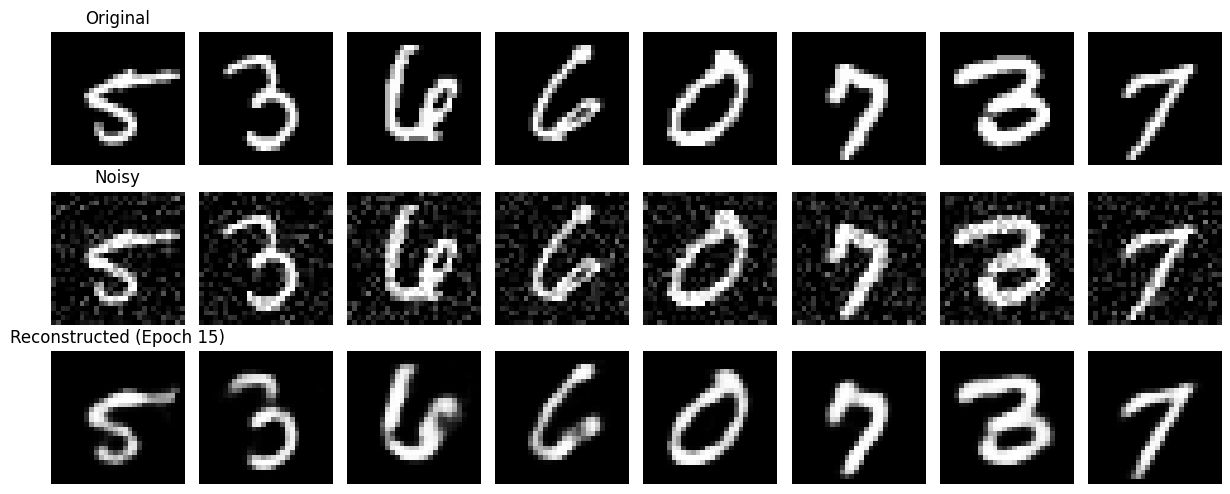

In [ ]:
num_epochs = 15
train_losses, val_losses, psnr_vals, ssim_vals = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs)
        recon, _ = model(noisy_imgs)
        loss = criterion(recon, imgs.view(-1, 28*28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, psnr_epoch, ssim_epoch = 0, [], []
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            noisy_imgs = add_noise(imgs)
            recon, _ = model(noisy_imgs)
            val_loss += criterion(recon, imgs.view(-1, 28*28)).item()

            imgs_np = imgs.cpu().numpy()
            recon_np = recon.view(-1, 1, 28, 28).cpu().numpy()
            for i in range(10):
                orig, rec = imgs_np[i][0], recon_np[i][0]
                psnr_epoch.append(peak_signal_noise_ratio(orig, rec, data_range=2))
                ssim_epoch.append(ssim(orig, rec, data_range=2))
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    psnr_vals.append(np.mean(psnr_epoch))
    ssim_vals.append(np.mean(ssim_epoch))

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | PSNR: {np.mean(psnr_epoch):.2f} | SSIM: {np.mean(ssim_epoch):.3f}")

    # Show intermediate reconstruction
    if (epoch+1) % 5 == 0:
        dataiter = iter(val_loader)
        imgs, _ = next(dataiter)
        noisy_imgs = add_noise(imgs).to(device)
        recon, _ = model(noisy_imgs)
        imgs = imgs.cpu().numpy()
        noisy_imgs = noisy_imgs.cpu().numpy()
        recon = recon.view(-1, 1, 28, 28).cpu().detach().numpy()

        fig, axes = plt.subplots(3, 8, figsize=(12, 5))
        for i in range(8):
            axes[0][i].imshow(imgs[i][0], cmap='gray'); axes[0][i].axis('off')
            axes[1][i].imshow(noisy_imgs[i][0], cmap='gray'); axes[1][i].axis('off')
            axes[2][i].imshow(recon[i][0], cmap='gray'); axes[2][i].axis('off')
        axes[0][0].set_title("Original")
        axes[1][0].set_title("Noisy")
        axes[2][0].set_title(f"Reconstructed (Epoch {epoch+1})")
        plt.tight_layout(); plt.show()

Training Curves: MSE, PSNR, SSIM

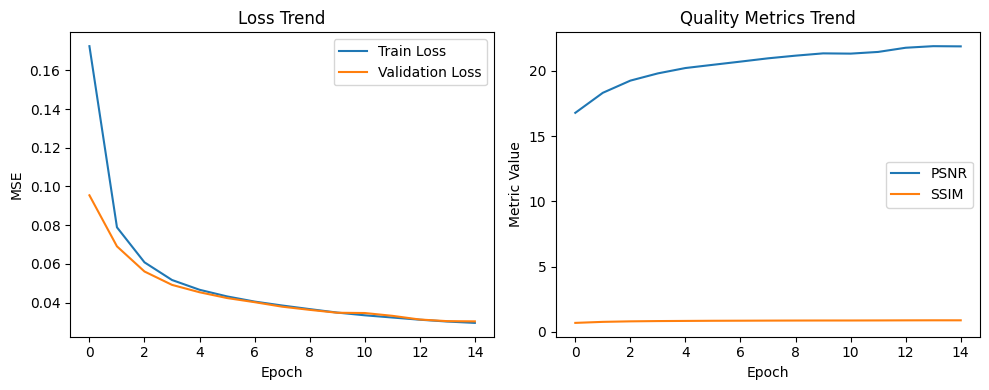

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.title("Loss Trend")
plt.subplot(1,2,2)
plt.plot(psnr_vals, label="PSNR")
plt.plot(ssim_vals, label="SSIM")
plt.xlabel("Epoch"); plt.ylabel("Metric Value"); plt.legend(); plt.title("Quality Metrics Trend")
plt.tight_layout(); plt.show()

Latent Feature Heatmap

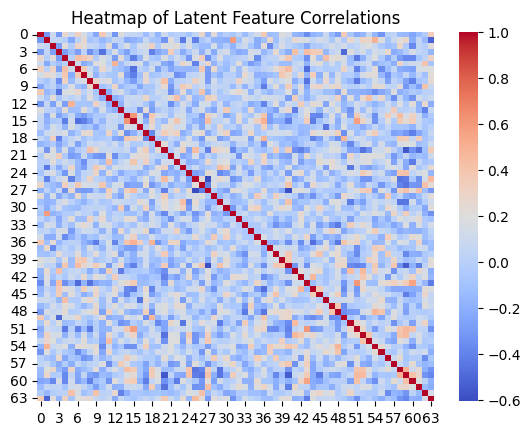

In [ ]:
model.eval()
latent_vectors = []
labels = []
with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs = imgs.to(device)
        _, latent = model(imgs)
        latent_vectors.append(latent.cpu().numpy())
        labels.extend(lbls.numpy())

latent_vectors = np.concatenate(latent_vectors)
labels = np.array(labels)

sns.heatmap(np.corrcoef(latent_vectors.T), cmap="coolwarm")
plt.title("Heatmap of Latent Feature Correlations")
plt.show()

 t-SNE Visualization of Latent Space

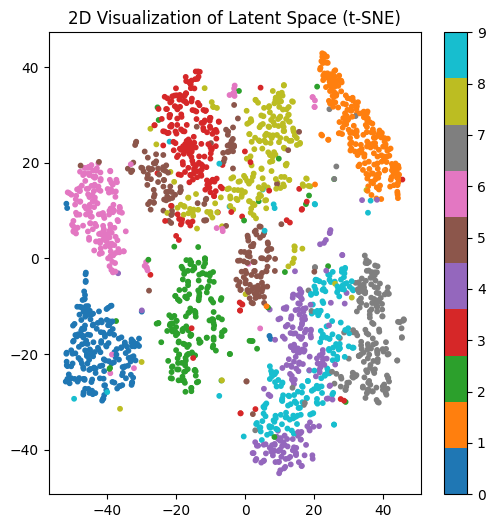

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors[:2000])
plt.figure(figsize=(6,6))
scatter = plt.scatter(latent_2d[:,0], latent_2d[:,1], c=labels[:2000], cmap='tab10', s=10)
plt.colorbar(scatter)
plt.title("2D Visualization of Latent Space (t-SNE)")
plt.show()

Visualize Average Encoded Representation per Digit

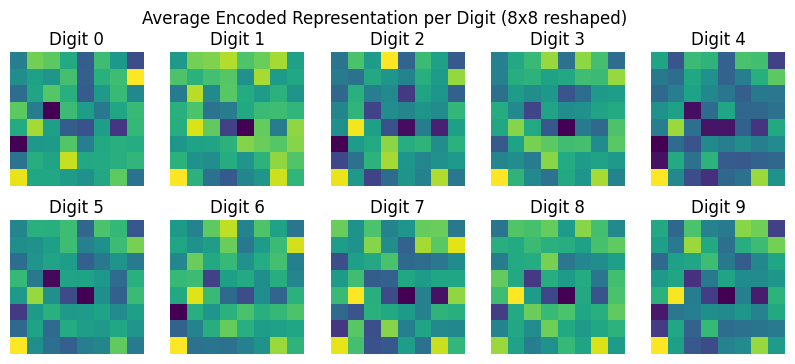

In [ ]:
digit_latents = {i: [] for i in range(10)}
with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs = imgs.to(device)
        _, latent = model(imgs)
        for i, lbl in enumerate(lbls):
            digit_latents[int(lbl.item())].append(latent[i].cpu().numpy())

plt.figure(figsize=(10,4))
for i in range(10):
    if len(digit_latents[i]) > 0:
        avg_vector = np.mean(np.stack(digit_latents[i]), axis=0)
        plt.subplot(2,5,i+1)
        plt.imshow(avg_vector.reshape(8,8), cmap="viridis")
        plt.title(f"Digit {i}")
        plt.axis("off")
plt.suptitle("Average Encoded Representation per Digit (8x8 reshaped)")
plt.show()
